# Correction with Linear Regression

這篇筆記是使用線性回歸（linear regression）來建立 storm-tracker 的溫、濕度校正公式。

我們在上一篇資料準備的筆記裡已經將兩種儀器的探空資料合併成分析要用的資料，包含欄位：

- **time**: 探空氣球釋放時間
- **P**: 氣壓
- **T_st**: storm-track 的溫度
- **RH_st**: storm-track 的相對濕度
- **U_st**: storm-track 的緯向風
- **V_st**: storm-track 的經向風
- **dT**: Vaisala 的溫度 - storm-track 的溫度（需要被校正的溫度）
- **dRH**: Vaisala 的相對濕度 - storm-track 的相對濕度（需要被校正的相對濕度）

讓我們先假設最簡單的情況：需要校正的溫、濕度值，單純的是氣壓、溫度、濕度的函數，不受風場和整個垂直剖面型態的影響。也就是說，我們需要建立以下兩個公式：

$dT = f(P, T_{st}, RH_{st})$

$dRH = f(P, T_{st}, RH_{st})$



In [2]:
import numpy as np
import pandas as pd
import os, sys, csv

# Read the prepared data
data = pd.read_csv('../data/iodata.csv')
print(data.head())
print(data.shape)

                key         time       P       T_st      RH_st      U_st  \
0  20180625_06_1000  20180625_06  1000.0  33.504632  62.417895 -1.217775   
1   20180625_06_999  20180625_06   999.0  33.362504  62.662493  2.042479   
2   20180625_06_998  20180625_06   998.0  33.183320  63.166699  5.502851   
3   20180625_06_997  20180625_06   997.0  33.025238  63.756463  1.987596   
4   20180625_06_996  20180625_06   996.0  32.892530  64.291565  6.566753   

       V_st        dT       dRH  
0 -1.217775 -2.004632  0.502106  
1  2.042479 -1.962504  0.437507  
2  5.502851 -1.863320  0.013301  
3  1.987596 -1.825238 -0.256463  
4  6.566753 -1.792530 -0.566564  
(261231, 9)


線性回歸可以用最簡單的 [`sklearn.linear_model.LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) 來達成。我們先簡單的把26萬筆資料全部丟進去計算，然後看看 $R^2$ ([coefficient of determination](https://zh.wikipedia.org/wiki/%E5%86%B3%E5%AE%9A%E7%B3%BB%E6%95%B0))。

In [5]:
# Linear model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

x = data.loc[:,['P','T_st','RH_st']]

# Initialize the model
model_t = linear_model.LinearRegression()
model_rh = linear_model.LinearRegression()

model_t.fit(x, data['dT'])
model_rh.fit(x, data['dRH'])

print('\ndT:')
print(model_t.score(x, data['dT']))

print('\ndRH:')
print(model_rh.score(x, data['dRH']))


dT:
0.4473939413147232

dRH:
0.20818215768661208


用 $R^2$ 來判定預測能力，簡單的說是越接近於1越好，看來我們的簡單線性模型預測能力很普通。讓我們從「真實值-預測值」的散佈圖來看看模型預測的特性。

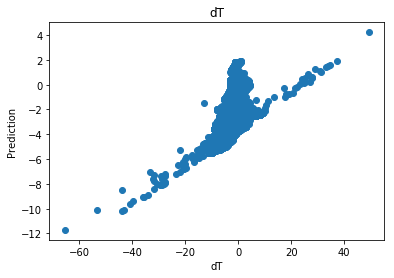

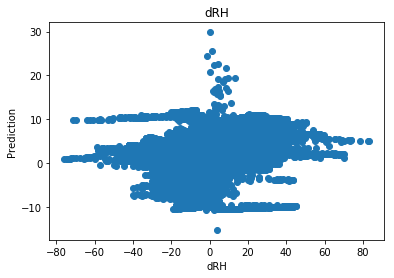

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

dT_predict = model_t.predict(x)
dRH_predict = model_rh.predict(x)

plt.scatter(data['dT'], dT_predict)
plt.xlabel('dT')
plt.ylabel('Prediction')
plt.title('dT')
plt.show()
plt.scatter(data['dRH'], dRH_predict)
plt.xlabel('dRH')
plt.ylabel('Prediction')
plt.title('dRH')
plt.show()

從散佈圖來看，溫度較正的值在趨勢上大致正確，但數值明顯篇小，而且在 0 附近似乎有另一個不同的分佈存在。而濕度的校正則相當隨機，看不出有明顯的趨勢。

從這個結果來看，僅用氣壓、溫度、濕度，配合線性回歸來預測校正值，並不是很理想的方法。